### Motivation

Rayner Teo, who is a popular YouTuber and an independent trader, uploaded a video introducing a simple trading strategy with high winning rate (https://www.youtube.com/watch?v=W8ENIXvcGlQ). The strategy aims to look for buying opportunities after a strong pullback while the market is in an uptrend. 

Although this strategy is applied on S&P 500 as an example in the video, Rayner also mentioned that the strategy can be used to trade individual stocks for more trading opportunities. This notebook aims to test the performance of this strategy in Hong Kong Stock Market.

### Rules
##### Entry:
1. The price is above the 200-day Moving Average, and
2. 10-period RSI is below 30
(buy on the next day's open)

##### Exit:
1. 10-period RSI is above 40, or
2. after 10 trading days 
(sell on the next day's open)

### Data
Daily stock prices of Index Constituents of Hang Seng Index are selected for testing. The date range is from the beginning of 2010 (or the date when the company is listed) to the end of 2021. The data are obtained through Yahoo Finance


### Simulation

In [1]:
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import copy

In [2]:
stock_list = pd.read_csv('stock list.csv')  # the strategy will be tested on these stocks
stock_list.head()

,code,stock_ch,stock_en
0,968,信義光能,XINYI SOLAR
1,1038,長江基建集團,CKI HOLDINGS
2,1044,恆安國際,HENGAN INT'L
3,1093,石藥集團,CSPC PHARMA
4,1109,華潤置地,CHINA RES LAND


In [3]:
stock_dfs = dict()  # mapping the stock name with corresponding dataframe of stock price
for idx, row in stock_list.iterrows():
    files = 'stock_price_2010_2021\{}.csv'.format(row['stock_en'])
    df_tmp = pd.read_csv(files)
    df_tmp.dropna(subset=['Close'], inplace=True)
    stock_dfs[row['stock_en']] = df_tmp
    
stock_dfs['XINYI SOLAR']  #Example: stock price of XINYI SOLAR

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-12,0.943908,1.311535,0.834613,1.132689,0.870278,355345299
1,2013-12-13,1.162497,1.500316,1.122753,1.410894,1.084031,653667111
2,2013-12-16,1.420829,1.440701,1.241984,1.291663,0.992423,248436693
3,2013-12-17,1.321471,1.391022,1.311535,1.371150,1.053495,153605170
4,2013-12-18,1.381086,1.619547,1.361214,1.589739,1.221443,352232913
...,...,...,...,...,...,...,...
1982,2021-12-24,13.080000,13.080000,13.080000,13.080000,13.080000,0
1983,2021-12-28,13.100000,13.200000,12.780000,13.040000,13.040000,19261148
1984,2021-12-29,12.960000,13.140000,12.860000,13.000000,13.000000,6354220
1985,2021-12-30,13.040000,13.140000,12.820000,13.000000,13.000000,15386701


In [4]:
# creating indicators for identifying entry and exist signal
def create_indicators(df):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The stock price data containing column name 'Close'
    
    Returns
    ----------
    pd.DataFrame
        DataFrame with indicators added in new colums
    '''
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['SMA200'] = talib.SMA(df['Close'], timeperiod = 200)
    df.dropna(subset = ['RSI','SMA200'], inplace=True)
    return df

In [5]:
# Make decisions according to the rules and indicators
def make_decisions(df):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The stock price data containing required indicators
    
    Returns
    ----------
    pd.DataFrame
        DataFrame with decisions (entry: +1, exist: -1, no_action: 0) added in new colums
    '''
    entry_filter = np.bitwise_and(df['RSI']<30, df['Close']>df['SMA200'])
    exit_filter1 = df['RSI'] > 40
    df['decisions'] = np.where(entry_filter, 1, np.where(exit_filter1, -1, 0))
    exit_filter2 = np.where(df['decisions']==1)[0]+10   # exit after 10 trading days 
    exit_filter2 = exit_filter2[np.where(exit_filter2 < len(df))]  # avoid out of index error after shifting 10 trading days
    df.iloc[exit_filter2, -1] = -1
    return df

In [6]:
# simulate the trading process
def simulate(df):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The stock price data containing decisions
    
    Returns
    ----------
    List
        Storing percentage gain/loss for each trade
        
    pd.DataFrame
        New column with buy and sell time point is added to input df
    '''
    cur_cost = 0  # the cost of currently holding stock. Buy fixed amount of value of stock for each trade
    PNL_each_trade = []  # Storing percentage gain/loss for each trade
    buy_and_sell_points = [] # append 1 if buy action occurred; 0 if no action; -1 if sell action occurred
    flag = 0  #buy the stock at open price if flag == 1, sell the stock at open price if flag == -1
    for idx, row in df.iterrows():
        if flag == 1 and cur_cost==0:  # if decided to buy stock at open price and currently not holding stock
            cur_cost=row['Open']
            buy_and_sell_points.append(1)
        elif flag == -1 and cur_cost != 0: # if decided to sell stock at open price and currently holding stock
            PNL_each_trade.append((row['Open']-cur_cost)/cur_cost)
            cur_cost = 0
            buy_and_sell_points.append(-1)
        else:        
            buy_and_sell_points.append(0)
        if row['decisions'] == 0: # if no decision made
            flag = 0
        elif row['decisions'] == 1:  # if decide to buy stock on next day at open price
            flag = 1
        else:  # if decide to sell stock on next day at open price
            flag = -1
    df['buy_sell_points'] = buy_and_sell_points
    return PNL_each_trade, df


In [7]:
# Perform simulation on each stock and record some performance statistics

log = dict()  # map stock name to performance statistics
log_df = dict() # map stock name to corresponding DataFrame for visualizing buy and sell point 
total_PNL = [] # aggregate the percentage gain/loss of each trade for each stock

stock_dfs_copy = copy.deepcopy(stock_dfs)

for stock_name, df in stock_dfs_copy.items():
    df = create_indicators(df)
    df = make_decisions(df)
    PNL, result = simulate(df)
    total_PNL.extend(PNL)
    log_df[stock_name] = result
    if len(PNL) != 0:  # if at least one trade is made
        num_of_trades = len(PNL)
        cum_PNL = sum(PNL)
        max_gain = max(PNL)
        min_gain = min(PNL)
        log[stock_name] = [num_of_trades, cum_PNL, max_gain, min_gain]
    else:
        log[stock_name] = [0, 0, 0, 0]


### Performance

In [8]:
# Analyze performance of strategy on each stock
df_log = pd.DataFrame(log)
df_log.index = ['Number of Trades', 'Cummulative Return', 'Max Return', 'Min Return']
df_log = df_log.T
df_log

,Number of Trades,Cummulative Return,Max Return,Min Return
XINYI SOLAR,2.0,0.013939,0.203470,-0.189531
CKI HOLDINGS,2.0,0.036419,0.018548,0.017870
HENGAN INT'L,0.0,0.000000,0.000000,0.000000
CSPC PHARMA,1.0,0.045187,0.045187,0.045187
CHINA RES LAND,1.0,-0.021327,-0.021327,-0.021327
...,...,...,...,...
XINYI GLASS,5.0,0.271926,0.135458,-0.069620
CNOOC,1.0,0.053086,0.053086,0.053086
CCB,1.0,-0.018462,-0.018462,-0.018462
CHINA MOBILE,0.0,0.000000,0.000000,0.000000


In [9]:
df_log.describe()

,Number of Trades,Cummulative Return,Max Return,Min Return
count,64.000000,64.000000,64.000000,64.000000
mean,2.265625,0.064317,0.051513,-0.001001
std,1.953769,0.113838,0.055815,0.050016
min,0.000000,-0.183836,-0.024476,-0.189531
25%,1.000000,0.000000,0.007937,-0.025775
50%,2.000000,0.035235,0.037145,0.000000
75%,3.000000,0.105543,0.072844,0.020110
max,7.000000,0.503400,0.212085,0.125671


In [10]:
# Visualize the buy and sell time point for a given stock
def plot_buy_sell_point(df, title):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The stock price data containing columns Date and buy_sell_points
    titel: str
        Title of the figure
    '''
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['buy'] = np.where(df['buy_sell_points']==1, df['Close'], np.nan)
    df['sell'] = np.where(df['buy_sell_points']==-1, df['Close'], np.nan)
    df['day_trade'] = np.where(df['buy_sell_points']==2, df['Close'], None)
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(df['Date'], df['Close'])
    ax.scatter(df['Date'], df['buy'], marker=6, color = 'g', label='buy', s=100)
    ax.scatter(df['Date'], df['sell'], marker=7, color = 'r', label='sell', s=100)
    ax.scatter(df['Date'], df['day_trade'], color = 'black', label='day trade', s=100)
    ax.legend()
    ax.title.set_text(title)


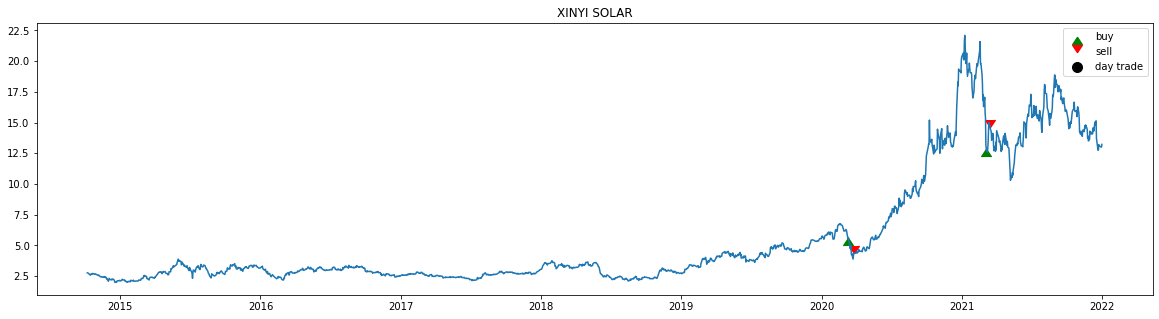

In [11]:
plot_stock = 'XINYI SOLAR'
plot_buy_sell_point(log_df[plot_stock], plot_stock )

Number of Trades is  145
Mean of Return is  0.02838830306884229
Standard Deviation of Return is  0.058743294817141516
Winning rate is  0.7448275862068966


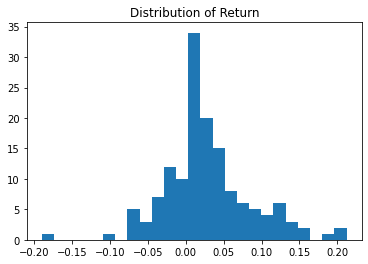

In [12]:
# Analyze distribution of the return by considering all trades made on all stock
plt.hist(total_PNL, bins=25)
plt.title('Distribution of Return')
num_gain = len(np.where(np.array(total_PNL)>=0)[0])
print("Number of Trades is ", len(total_PNL))
print("Mean of Return is ", np.mean(total_PNL))
print("Standard Deviation of Return is ", np.std(total_PNL))
print("Winning rate is ", num_gain/len(total_PNL))

### Observations

1. This strategy has a winning rate of 74.48%, which is quite impressive for a simple strategy.
2. This strategy only produce few buy signals for each stock. Over the trading period from year 2010 to 2021, on average, only 2.27 trades are made per each stock. In order to discover more trading opportunities, one may apply this strategy on more stocks or apply this strategy on more frequent stock price data (e.g. hourly stock price)
3. A huge loss is still possible although the stock is bought after a strong pullback. For example, a trade causes a loss of 19% in the simulation. A rule for loss control should help improve the performance.

### Applying Loss Limit

In order to control the loss, a loss limit should be set for each trade. The stock will be sold immediately once the loss limit is reached. The following code tries to figure out the most suitable loss limit.

In [13]:
# apply loss limit during simulation
def simulate_with_loss_limit(df, loss_limit):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The stock price data containing decisions
    loss_limit: float
        The loss_limit of each trade
        
    Returns
    ----------
    List
        Storing percentage gain/loss for each trade
        
    pd.DataFrame
        New column with buy and sell time point is added to input df
    '''
    cur_cost = 0  # the cost of currently holding stock. Buy fixed amount of value of stock for each trade
    PNL_each_trade = []  # Storing percentage gain/loss for each trade
    buy_and_sell_points = [] # append 1 if buy action occurred; 0 if no action; -1 if sell action occurred
    actions_flag = 0  # record the buy/sell actions made in a day; -1 for sell action; 0 for no action; 1 for buy action; 2 for daytrade action
    flag = 0  #buy the stock at open price if flag == 1, sell the stock at open price if flag == -1
    for idx, row in df.iterrows():
        # When market open, execute trading decision
        if flag == 1 and cur_cost==0:  # if decided to buy stock at open price and currently not holding stock
            cur_cost=row['Open']
            actions_flag = 1
        elif flag == -1 and cur_cost != 0: # if decided to sell stock at open price and currently holding stock
            PNL_each_trade.append((row['Open']-cur_cost)/cur_cost)
            cur_cost = 0
            actions_flag = -1
        # During trading period, monitor loss limit
        if cur_cost != 0:
            stop_loss_price = cur_cost * (1-loss_limit)
            if row['Low'] <= stop_loss_price:
                PNL_each_trade.append(-loss_limit)  
                cur_cost = 0
                if actions_flag == 1: # if bought the stock at open price today
                    actions_flag = 2  # buy and sell actions made on the same day (daytrade action)
                elif actions_flag == 0: 
                    actions_flag = -1
        # After market closed, make decision for tomorrow
        if row['decisions'] == 0: # if no decision made
            flag = 0
        elif row['decisions'] == 1:  # if decide to buy stock on next day at open price
            flag = 1
        else:  # if decide to sell stock on next day at open price
            flag = -1
        # Record trading actions today
        buy_and_sell_points.append(actions_flag)
        actions_flag = 0
    df['buy_sell_points'] = buy_and_sell_points
    return PNL_each_trade, df

Distribution of Return


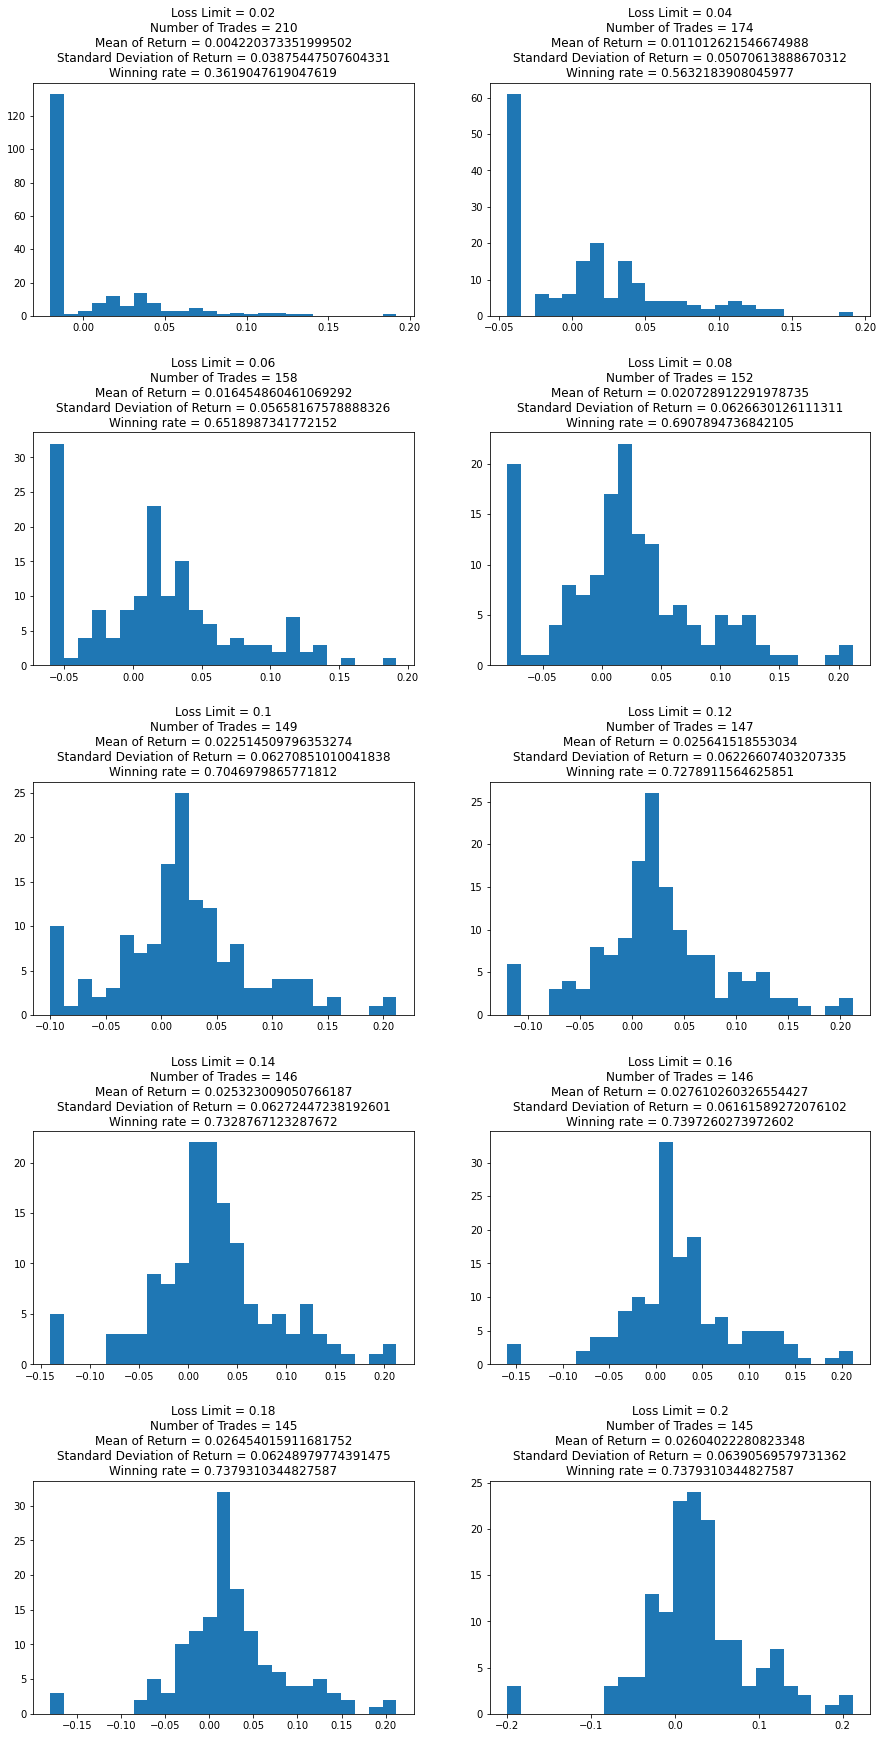

In [14]:
# Perform simulation on each stock for different loss limit and visualize the distribution of return

fig, ax = plt.subplots(5,2, figsize=(15,30))
plt.subplots_adjust(hspace=0.5)
axes = ax.flatten()
graph = 0
print("Distribution of Return")
for loss_limit in np.linspace(0.02, 0.2, 10):
    loss_limit = round(loss_limit, 2)
    log2 = dict()  # map stock name to performance statistics
    log_df2 = dict() # map stock name to corresponding DataFrame for visualizing buy and sell point 
    total_PNL2 = [] # aggregate the percentage gain/loss of each trade for each stock

    stock_dfs_copy = copy.deepcopy(stock_dfs)

    for stock_name, df in stock_dfs_copy.items():
        df = create_indicators(df)
        df = make_decisions(df)
        PNL, result = simulate_with_loss_limit(df, loss_limit)
        total_PNL2.extend(PNL)
        log_df2[stock_name] = result
        if len(PNL) != 0:  # if at least one trade is made
            num_of_trades = len(PNL)
            cum_PNL = sum(PNL)
            max_gain = max(PNL)
            min_gain = min(PNL)
            log2[stock_name] = [num_of_trades, cum_PNL, max_gain, min_gain]
        else:
            log2[stock_name] = [0, 0, 0, 0]

    # Analyze distribution of the return by considering all trades made on all stock
    num_gain = len(np.where(np.array(total_PNL2)>=0)[0])
    axes[graph].hist(total_PNL2, bins=25)
    axes[graph].title.set_text('''Loss Limit = {}\nNumber of Trades = {}\nMean of Return = {}\nStandard Deviation of Return = {}\nWinning rate = {}'''.format(loss_limit, len(total_PNL2), np.mean(total_PNL2), np.std(total_PNL2), num_gain/len(total_PNL2)))
    graph+=1

From the figures above, it seems that the most suitable loss limit is between 0.14 and 0.18 for each trade.

### Conclusion

From the simulation above, this strategy also shows a high winning rate in Hong Kong Stock Market. The strategy may be improved by searching the best value of RSI to find the entry and exit point. Also, some indicators may be better than 200-day moving average for identifying uptrend.